In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trained-model/model_keras.h5
/kaggle/input/training-images-downsizedmore/training_data_processed4.npz
/kaggle/input/training-imagesdownsized/training_data_processed3.npz
/kaggle/input/image-detection-images/images.npy
/kaggle/input/images-personally-labeled/training_data_processed5.npz
/kaggle/input/trained-model-nou/model_keras_nou.h5
/kaggle/input/cuprogram-facut/training_data_processed5.npz


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics

import codecs
import glob
import json
import numpy as np

from tqdm import tqdm
import sys

from PIL import Image, ImageOps
import cv2 as cv

# Library for the Neural Network
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from keras import backend as K 

# Default image sizes
default_x = 100
default_y = 50

{'x': 0.12075471698113208, 'y': 0.09904153354632587} 313
(313, 530, 3)


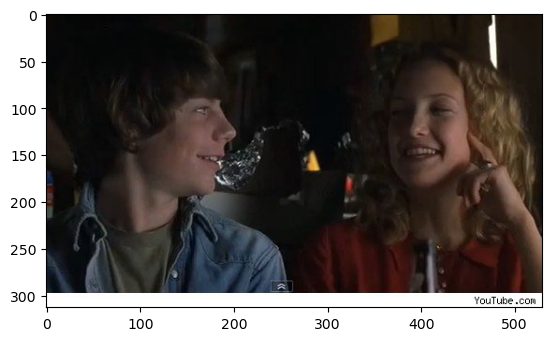

In [10]:
images_to_train = np.load("../input/image-detection-images/images.npy", allow_pickle=True)

image_det = images_to_train[200]
img = image_det[0]
img = Image.fromarray(img,'RGB')
up_point = image_det[1][0]["points"][0]
down_point = image_det[1][0]["points"][1]
shape_x = image_det[0].shape[1]
shape_y = image_det[0].shape[0]
print(up_point, shape_y)
print(image_det[0].shape)

plt.imshow(img)

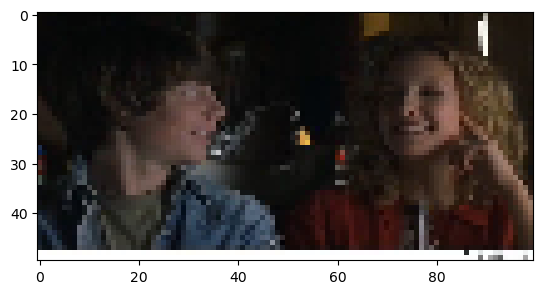

In [11]:
image_adjusted = np.uint8(cv.resize(np.uint8(img), (default_x, default_y)))
plt.imshow(image_adjusted)

In [12]:
def create_masks_for_training():
    global default_x
    global default_y
    
    X = np.empty((0, default_y, default_x, 3))
    y = np.empty((0, default_y, default_x, 3))
    
    for image in tqdm(images_to_train):
        shape_x = image[0].shape[1]
        shape_y = image[0].shape[0]
        image_mask = np.zeros((shape_y, shape_x, 3))
        
        for bbox in image[1]:
            up_point = bbox["points"][0]
            down_point = bbox["points"][1]
            image_mask[int(up_point['y']*shape_y):int(down_point['y']*shape_y), int(up_point['x']*shape_x):int(down_point['x']*shape_x), 0] = 255
            
            image_adjusted = np.uint8(cv.resize(np.uint8(image[0]),(default_x, default_y)))
            image_mask = np.uint8(cv.resize(np.uint8(image_mask), (default_x, default_y)))
            
        if (image_adjusted.shape != (default_y, default_x, 3)):
            continue
                
        image_adjusted = np.reshape(image_adjusted, (1, default_y, default_x, 3))
        image_mask = np.reshape(image_mask, (1, default_y, default_x, 3))
            
        X = np.vstack((X, image_adjusted))
        y = np.vstack((y, image_mask))
            
    return X,y
    
X, y = create_masks_for_training()
        

100%|██████████| 409/409 [00:12<00:00, 31.68it/s]


In [13]:
np.savez('training_data_processed5.npz', train=X, train_labels=y)

(397, 50, 100, 3) (397, 50, 100, 3)


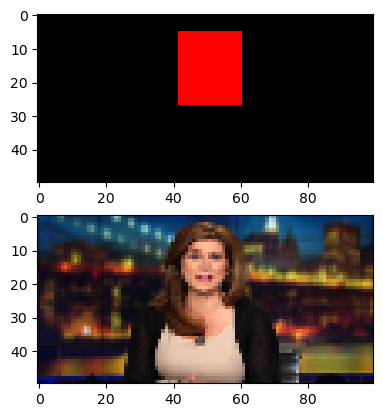

In [14]:
print (X.shape, y.shape)
fig = plt.figure()
fig.add_subplot(2,1,1)

plt.imshow(y[100], cmap='Greys')
fig.add_subplot(2,1,2)

plt.imshow(Image.fromarray(np.uint8(X[100]), 'RGB'))

In [15]:
print (glob.glob('../input/*more/*.npz'))

['../input/training-images-downsizedmore/training_data_processed4.npz']


In [17]:
def load_processed_data():
    # load training data

    X = np.empty((0, default_y, default_x, 3))
    y = np.empty((0, default_y* default_x* 1))
    training_data = glob.glob('../input/training-images-downsizedmore/training_data_processed4.npz')
    training_data.append(glob.glob('../input/images-personally-labeled/training_data_processed5.npz')[0])
    print (training_data)

    # if no data, exit
    if not training_data:
        print("Data not found, exit")
        sys.exit()
        

    for single_npz in training_data:
        with np.load(single_npz) as data:
            train = data['train']
            train_labels = data['train_labels']
        X = np.vstack((X, train))
        del train
        
        for label in tqdm(train_labels):             
            img = cv.cvtColor(label.astype('uint8'), cv.COLOR_BGR2GRAY)
            y = np.vstack((y, img.ravel()))
        del train_labels
    return X, y

X, y = load_processed_data()


['../input/training-images-downsizedmore/training_data_processed4.npz', '../input/images-personally-labeled/training_data_processed5.npz']


100%|██████████| 484/484 [00:02<00:00, 164.29it/s]


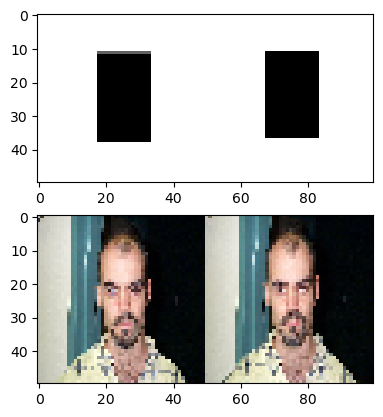

In [18]:
img_nr = 800
img = np.uint8(X[img_nr])
img_label = np.uint8(y[img_nr])
img_label = img_label.reshape(default_y, default_x)

fig = plt.figure()
fig.add_subplot(2,1,1)

plt.imshow(img_label, cmap='Greys')
fig.add_subplot(2,1,2)

plt.imshow(img)

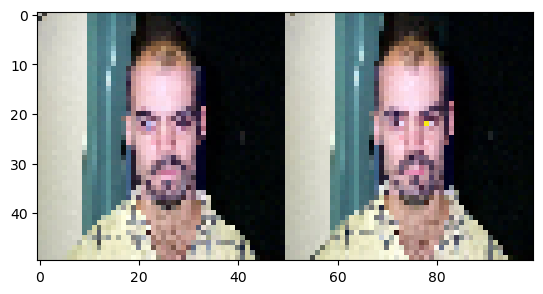

In [19]:
test_img = img
pred = img_label
r = cv.split(test_img)[0]
g = cv.split(test_img)[1]
b = cv.split(test_img)[2]
b = b + pred
img = cv.merge([r,g,b])
plt.imshow(img)

In [20]:
X = (X/(float(np.amax(X[0]))))
y = (y/(float(np.amax(y))))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

print (np.amax(X[0]))
print (np.amax(y[0]))

1.0
1.0


In [24]:
del X
del y

NameError: name 'X' is not defined

In [25]:
K.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation = 'relu',data_format="channels_last", input_shape = (default_y, default_x, 3)))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(3, (5, 5), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(3, (3, 3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(y_train.shape[-1], activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(y_train.shape[-1], activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(y_train.shape[-1], activation = 'sigmoid'))
model.add(layers.Dropout(0.2))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 98, 3)         84        
                                                                 
 dropout (Dropout)           (None, 48, 98, 3)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 49, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 45, 3)         228       
                                                                 
 dropout_1 (Dropout)         (None, 20, 45, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 43, 3)         84        
                                                        

In [30]:
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)

callbacks = [checkpoint]

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam')
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid,y_valid),
    epochs = 1, 
    verbose = 1,
    batch_size = 2
)

308/308 [==============================] - 210s 676ms/step - loss: 0.5904 - val_loss: 0.2498


In [32]:
#Save the model
model.save_weights('model_wieghts_nou.h5')
model.save('model_keras_nou.h5')

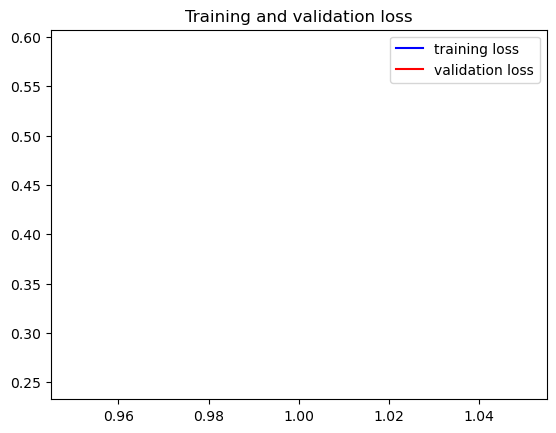

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label = "training loss")
plt.plot(epochs, val_loss, 'r', label = "validation loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 171ms/step


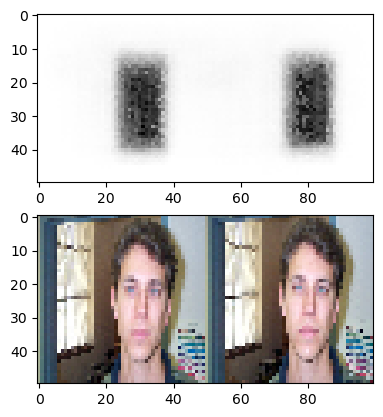

In [37]:
test_img = X_valid[22].reshape(1,default_y, default_x, 3)
pred = model.predict(test_img)
pred = pred*255

test_img = test_img.reshape(default_y, default_x, 3)
pred = pred.reshape(default_y, default_x)


fig = plt.figure()
fig.add_subplot(2,1,1)

plt.imshow(pred, cmap='Greys')
fig.add_subplot(2,1,2)

plt.imshow(test_img)

1/1 [==============================] - 0s 44ms/step


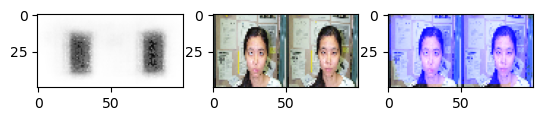

In [38]:
image_number = 67
test_img = X_valid[image_number].reshape(1,default_y, default_x, 3)
pred = model.predict(test_img)
pred = pred*255

test_img = test_img.reshape(default_y, default_x, 3)
pred = pred.reshape(default_y, default_x)


fig = plt.figure()
fig.add_subplot(1,3,1)

plt.imshow(pred, cmap='Greys')
fig.add_subplot(1,3,2)
plt.imshow(test_img)
# Blending the images with 0.3 and 0.7 
r = cv.split(test_img)[0]
g = cv.split(test_img)[1]
b = cv.split(test_img)[2]
b = b + pred
img = cv.merge([r,g,b])
fig.add_subplot(1,3,3)
plt.imshow(img)

In [39]:
print (glob.glob('../input/trained-model*/*'))

['../input/trained-model/model_keras.h5', '../input/trained-model-nou/model_keras_nou.h5']


In [40]:
path_to_model = glob.glob("../input/trained-model-nou/model_keras_nou.h5")[0]
new_model = load_model(path_to_model)

1/1 [==============================] - 0s 337ms/step


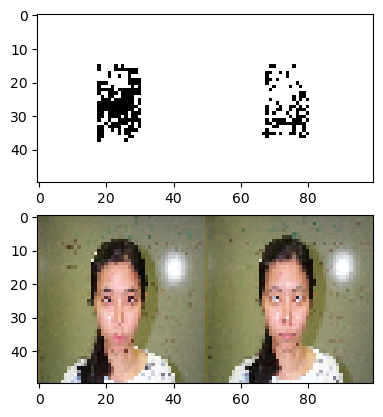

In [41]:
image_number = 39
test_img = X_valid[image_number].reshape(1,default_y, default_x, 3)
pred = new_model.predict(test_img)
pred = pred*255

test_img = test_img.reshape(default_y, default_x, 3)
pred = pred.reshape(default_y, default_x)
pred[pred>100] = 255
pred[pred<=100] = 0


fig = plt.figure()
fig.add_subplot(2,1,1)

plt.imshow(pred, cmap='Greys')
fig.add_subplot(2,1,2)
plt.imshow(test_img)

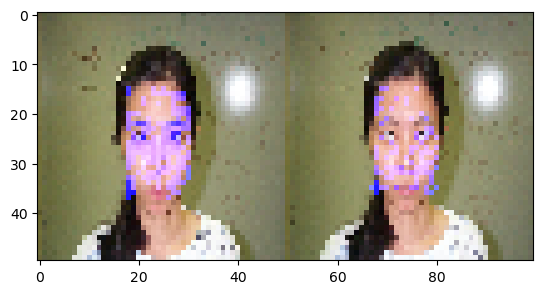

In [42]:
r = cv.split(test_img)[0]
g = cv.split(test_img)[1]
b = cv.split(test_img)[2]
b = b + pred
img = cv.merge([r,g,b])
plt.imshow(img)